#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [8]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\istom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\istom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

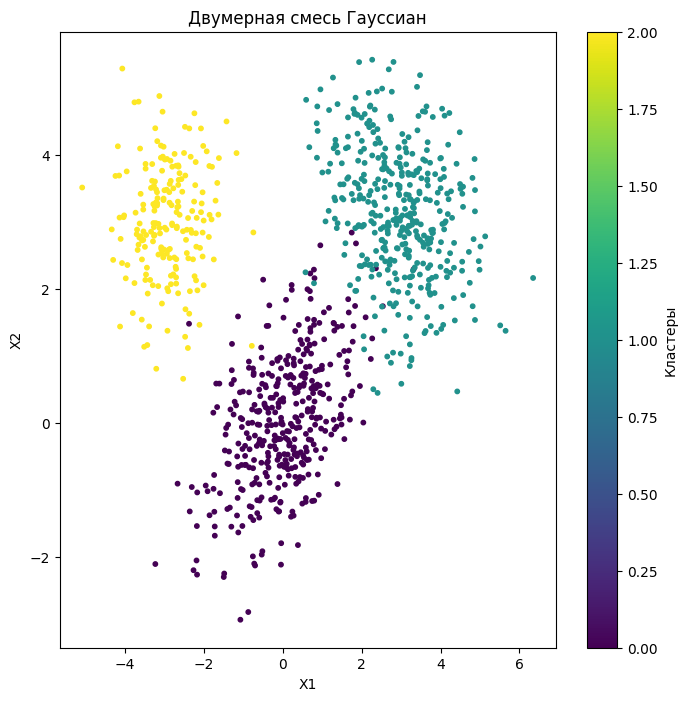

In [9]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

Оптимальное число кластеров K: 3


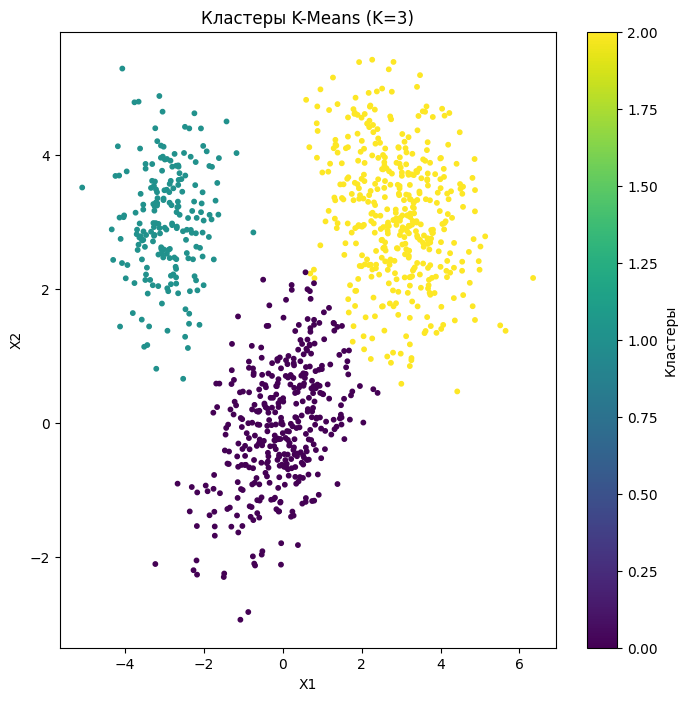

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_range = range(2, 11) 
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Оптимальное число кластеров K: {optimal_k}")


kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = kmeans.fit_predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='viridis', s=10)
plt.title(f"Кластеры K-Means (K={optimal_k})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

Лучшие параметры: eps=0.3, min_samples=9
Лучший F1-score: 0.9954


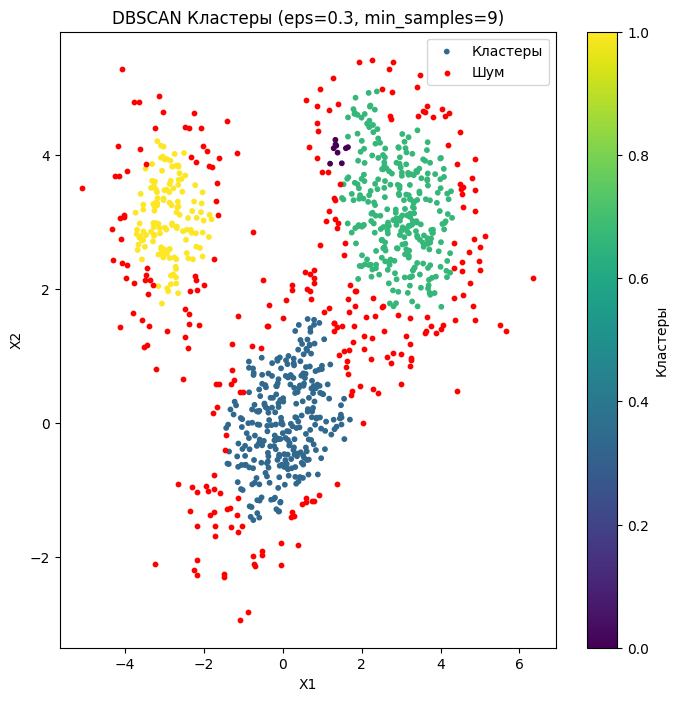

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.optimize import linear_sum_assignment

def match_labels(true_labels, predicted_labels):
    unique_true = np.unique(true_labels)
    unique_pred = np.unique(predicted_labels)
    unique_pred = unique_pred[unique_pred != -1]

    if len(unique_pred) == 0:
        return predicted_labels 

    cost_matrix = np.zeros((len(unique_true), len(unique_pred)))
    for i, true_label in enumerate(unique_true):
        for j, pred_label in enumerate(unique_pred):
            cost_matrix[i, j] = -np.sum((true_labels == true_label) & (predicted_labels == pred_label))

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = {unique_pred[col]: unique_true[row] for row, col in zip(row_ind, col_ind)}

    matched_labels = np.array([label_mapping.get(label, -1) for label in predicted_labels])
    return matched_labels

def evaluate_clustering(true_labels, predicted_labels):
    """Оценка метрик Precision, Recall и F1-score."""
    mask = predicted_labels != -1
    true_labels = true_labels[mask]
    predicted_labels = predicted_labels[mask]

    if len(set(predicted_labels)) < 2:
        return 0, 0, 0

    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
    return precision, recall, f1

eps_values = np.linspace(0.3, 1.5, 10)
min_samples_values = range(3, 10) 
best_f1 = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        predicted_labels = dbscan.fit_predict(X)
        matched_labels = match_labels(labels, predicted_labels)
        precision, recall, f1 = evaluate_clustering(labels, matched_labels)

        if f1 > best_f1:
            best_f1 = f1
            best_params = (eps, min_samples)

print(f"Лучшие параметры: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Лучший F1-score: {best_f1:.4f}")

dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
final_predicted_labels = dbscan.fit_predict(X)

final_matched_labels = match_labels(labels, final_predicted_labels)
plt.figure(figsize=(8, 8))

mask_noise = final_predicted_labels == -1
mask_clusters = ~mask_noise

plt.scatter(X[mask_clusters, 0], X[mask_clusters, 1], c=final_matched_labels[mask_clusters], cmap='viridis', s=10, label="Кластеры")
plt.scatter(X[mask_noise, 0], X[mask_noise, 1], c='red', s=10, label="Шум")
plt.title(f"DBSCAN Кластеры (eps={best_params[0]}, min_samples={best_params[1]})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.legend()
plt.show()


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

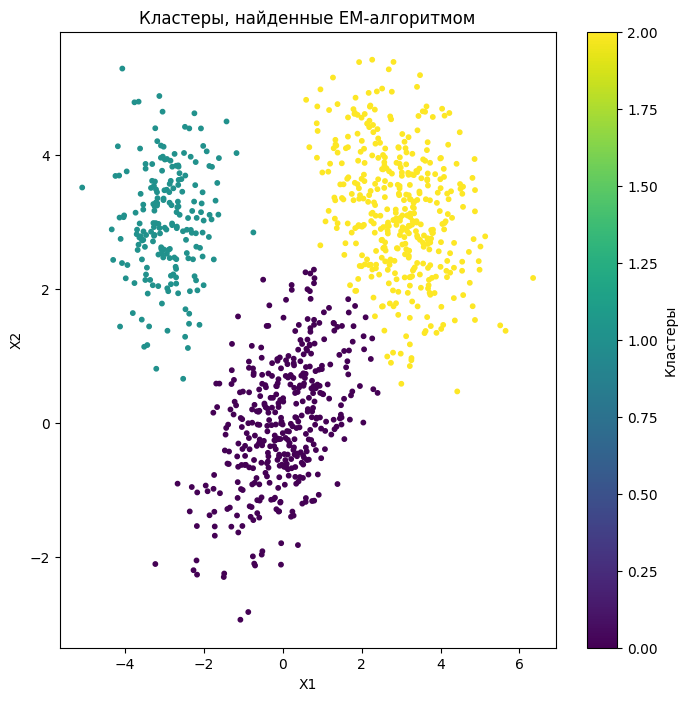

Log-likelihood на каждой итерации: [-3844.182194173036, -3762.8731838325725, -3733.699810784649, -3717.175499894271, -3704.1101504726016, -3690.842594654153, -3674.6868575307303, -3654.030842861448, -3632.4645807496963, -3620.7548351219916, -3618.7190349297807, -3618.59543079806, -3618.5899125783408, -3618.5896550310545, -3618.5896376015235, -3618.5896344413045, -3618.589633350879, -3618.5896329229495]


In [12]:
from scipy.stats import multivariate_normal
def initialize_parameters(X, n_clusters):
    n_features = X.shape[1]
    weights = np.ones(n_clusters) / n_clusters 
    means = np.random.uniform(X.min(axis=0), X.max(axis=0), size=(n_clusters, n_features))
    covariances = np.array([np.eye(n_features) for _ in range(n_clusters)]) 
    return weights, means, covariances

def e_step(X, weights, means, covariances):
    n_samples = X.shape[0]
    n_clusters = len(weights)
    responsibilities = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(X, responsibilities):
    n_samples, n_features = X.shape
    n_clusters = responsibilities.shape[1]
    
    Nk = responsibilities.sum(axis=0)

    weights = Nk / n_samples

    means = np.dot(responsibilities.T, X) / Nk[:, None]

    covariances = []
    for k in range(n_clusters):
        diff = X - means[k]
        cov_k = np.dot((responsibilities[:, k][:, None] * diff).T, diff) / Nk[k]
        covariances.append(cov_k)
    covariances = np.array(covariances)

    return weights, means, covariances

def log_likelihood(X, weights, means, covariances):
    """Расчет log-likelihood для текущих параметров"""
    n_samples = X.shape[0]
    n_clusters = len(weights)
    likelihood = np.zeros(n_samples)

    for k in range(n_clusters):
        likelihood += weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])

    return np.sum(np.log(likelihood))

def em_algorithm(X, n_clusters):
    weights, means, covariances = initialize_parameters(X, n_clusters)
    log_likelihoods = []

    for iteration in range(1000):
        responsibilities = e_step(X, weights, means, covariances)

        weights, means, covariances = m_step(X, responsibilities)

        ll = log_likelihood(X, weights, means, covariances)
        log_likelihoods.append(ll)

        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-6:
            break

    return weights, means, covariances, responsibilities, log_likelihoods

n_clusters = 3
weights, means, covariances, responsibilities, log_likelihoods = em_algorithm(X, n_clusters)

predicted_labels = np.argmax(responsibilities, axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', s=10)
plt.title("Кластеры, найденные EM-алгоритмом")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

print("Log-likelihood на каждой итерации:", log_likelihoods)

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

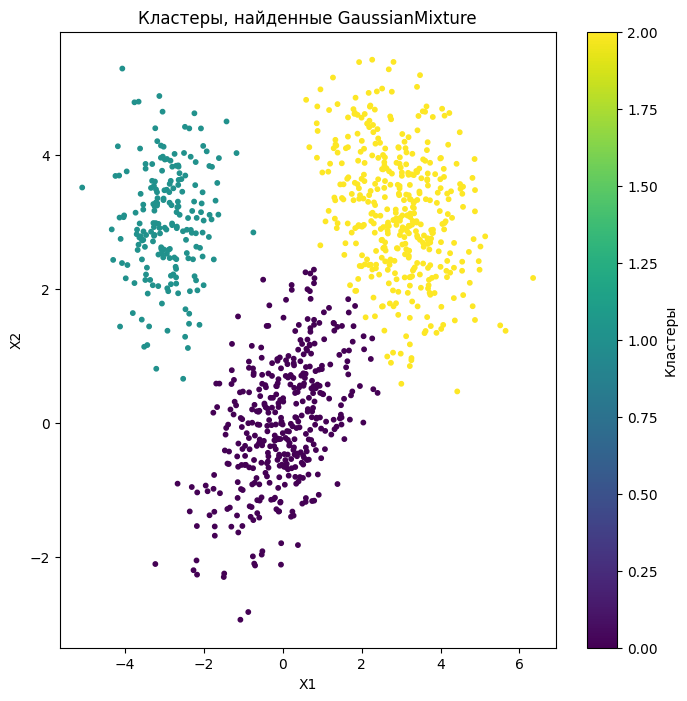

In [13]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

n_clusters = 3

gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(X)

gmm_labels = gmm.predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("Кластеры, найденные GaussianMixture")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()